# 编程基础期末大作业
### 宋浩天 应用统计 2023103378

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import statsmodels.api as sm
from plotnine import *
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 类的定义和函数定义

In [2]:
class BaseClassifier:
    def __init__(self, model):
        self.model = model
        self.best_params_ = None

    def train(self, X_train, y_train):

        self.tune_hyperparameters(X_train, y_train)

        self.model.fit(X_train, y_train)

    def predict(self, X_test):

        return self.model.predict(X_test)

    def evaluate(self, X_test, y_test):

        y_pred = self.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        print(f'Accuracy: {accuracy:.2f}')
        print('Classification Report:\n', classification_report(y_test, y_pred))
        return y_pred

    def tune_hyperparameters(self, X_train, y_train):
        raise NotImplementedError("tune_hyperparameters method should be implemented in subclasses.")

    def cross_validate(self, X, y, num_folds=5):
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

        accuracies = cross_val_score(self.model, X, y, cv=kf, scoring='accuracy')
        print(f'Cross-validated Accuracy: {np.mean(accuracies):.2f} (±{np.std(accuracies):.2f})')
        print('Best Parameters:', self.best_params_)


class LogisticRegressionClassifier(BaseClassifier):
    def __init__(self):
        super().__init__(LogisticRegression(penalty='l2', C=1e10))

    def tune_hyperparameters(self, X_train, y_train):
        self.best_params_ = None


class DecisionTreeClassifierWrapper(BaseClassifier):
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        super().__init__(DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf
        ))

    def tune_hyperparameters(self, X_train, y_train):
        # 使用网格搜索进行参数调优
        param_grid = {
            'max_depth': [None, 5, 7,10,13, 15],
            'min_samples_split': [2,3, 5,7, 10],
            'min_samples_leaf': [1, 2, 4]
        }

        grid_search = GridSearchCV(self.model, param_grid, cv=5, scoring='accuracy')

        grid_search.fit(X_train, y_train)

        # 获取最优参数
        self.best_params_ = grid_search.best_params_
        self.model = DecisionTreeClassifier(**self.best_params_)
        print(self.model)
        # self.model.fit(X_train, y_train)

In [3]:
# 对原始数据进行处理
def man_data(X1, X2):
    temp1 = []
    temp2 = []
    for i in range(len(X1)):
        for j in range(len(X2)):
            if X1[i][0] == X2[j][0]:
                temp1.append(X2[j])
    temp11 = np.delete(temp1, [0], axis=1)  # 根据胜负表中的第一支队伍，挑出它的数据
    for i in range(len(X1)):
        for j in range(len(X2)):
            if X1[i][2] == X2[j][0]:
                temp2.append(X2[j])
    temp22 = np.delete(temp2, [0], axis=1)  # 根据胜负表中的第二支队伍，挑出它的数据

    temp = []
    for i in range(len(temp11)):
        temp.append(temp11[i]-temp22[i])  # 将两组数据相减作为训练集
    c = 0
    game_res = []
    for i in range(len(X1)):
        if X1[i][1] > X1[i][3]:
            game_res.append(1)
            c = c+1
        else:
            game_res.append(0)   # 根据比分构造出胜负情况，作为训练集
    return temp, game_res


def draw(pre, game_res):
    res_pre = []
    res_fact = []
    for i in range(len(pre)):
        if pre[i] == 'N':
            res_pre.append(0.5)
        else:
            res_pre.append(1)
    for i in range(len(game_res)):
        if game_res[i] == 'N':
            res_fact.append(0.5)
        else:
            res_fact.append(1)  # 胜利为1，失败为0.5，可视化预测与实际结果
    game_count = [i for i in range(len(pre))]
    xticks = np.arange(len(game_count))

    fig, ax = plt.subplots(figsize=(10, 7))
    # 宽度，这里选择0.25
    ax.bar(xticks, res_pre, width=0.25, label="predict", color="red")
    # 通过微调x轴坐标来调整新增柱子的位置
    ax.bar(xticks + 0.25, res_fact, width=0.25, label="fact", color="blue")

    ax.set_title("Comparing Result", fontsize=15)
    ax.set_xlabel("game_count")
    ax.set_ylabel("result")
    ax.legend()

    # 最后调整x轴标签的位置
    ax.set_xticks(xticks + 0.25)
    ax.set_xticklabels(game_count)
    plt.show()


#对预测错误的场次进行分析
def analyse_res(pre, game_res, Rk):
    false_res = []
    print('预测错误的场次队伍分数差：')
    for i in range(len(pre)):
        if (pre[i]!= game_res.iloc[i, :]).all():
            row_index = game_res.index[i]
            false_res.append(X1[row_index][0])
            false_res.append(X1[row_index][2])  # 挑出预测错误的队伍
            print(X1[row_index][1] - X1[row_index][3])  # 输出此次比赛的分数差

    false_res_index1 = []
    false_res_index2 = []
    for i in range(0, len(false_res), 2):
        for j in range(len(X2)):
            if false_res[i] == X2[j][0]:
                false_res_index1.append(j)
    for i in range(1, len(false_res), 2):
        for j in range(len(X2)):
            if false_res[i] == X2[j][0]:
                false_res_index2.append(j)
    false_res_index = np.array(false_res_index1) - np.array(false_res_index2)  # 查看两支队伍最终排名的差距
    print('预测错误的场次队伍战力差：')
    print(false_res_index)

    false_res_index3 = []
    false_res_index4 = []
    for i in range(0, len(false_res), 2):
        for j in range(len(Rk)):
            if false_res[i] == Rk[j][1]:
                false_res_index3.append(j)
    for i in range(1, len(false_res), 2):
        for j in range(len(Rk)):
            if false_res[i] == Rk[j][1]:
                false_res_index4.append(j)
    false_res_index = np.array(false_res_index3) - np.array(false_res_index4)  # 查看两支队伍最终排名的差距
    print('预测错误的场次队伍赛季终排名差：')
    print(false_res_index)


## 数据预处理

In [4]:
    a = pd.read_csv(r'WL.txt')  # 2002-2003赛季部分比赛胜负表
    f = np.array(a)
    delete_y = [0, 1, 6, 7, 8, 9]  # 删掉不重要的数据
    X1 = np.delete(f, delete_y, axis=1)

    b = pd.read_csv(r'2002-2003team.txt')  # 2002-2003赛季球队数据表
    f1 = np.array(b)
    delete_y=[0, 2, 3, 4, 5, 6, 8, 11, 13, 14, 24]# 删掉不重要的数据
    X2 = np.delete(f1, delete_y, axis=1)
    # 根据逐步回归结果需再删掉以下三个变量
    # delete_y2 = [7, 9, 11]
    # X2 = np.delete(X2, delete_y2, axis=1)

    c = pd.read_csv(r'2002-2003Rk.txt')  # 2002-2003赛季球队排名表
    f2 = np.array(c)

    d = pd.read_csv(r'DET.txt')  # 2002-2003赛季DET队部分胜场表
    f3 = np.array(d)

    for i in range(len(X2)):
        if X2[i][0][-1] == '*':
            X2[i][0] = X2[i][0][:-1]  # 队伍后面带*的删掉

    temp, game_res = man_data(X1, X2)

## 直方图和箱线图

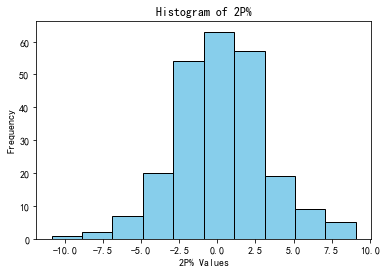

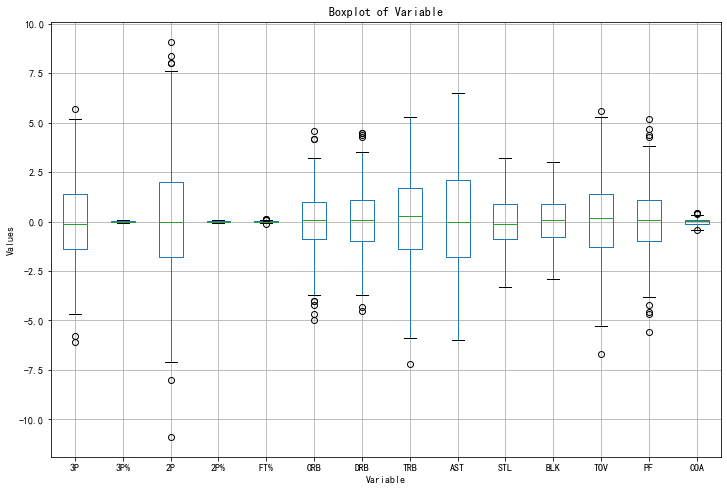

In [5]:
    pd_temp = pd.DataFrame(temp)
    columns=['3P','3P%','2P','2P%','FT%','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','COA']
    # 逐步回归后的变量如下
    # columns = ['3P', '3P%', '2P', '2P%', 'FT%', 'ORB', 'TRB', 'STL', 'TOV', 'PF', 'COA']
    pd_temp.columns = columns
    pd_game_res = pd.DataFrame(game_res)

    #绘制直方图
    plt.hist(pd_temp.iloc[:,2], bins=10, color='skyblue', edgecolor='black')
    plt.xlabel('2P% Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of 2P%')
    plt.show()

    #绘制箱线图
    plt.figure(figsize=(12, 8))
    pd_temp.boxplot()
    plt.xlabel('Variable')
    plt.ylabel('Values')
    plt.title('Boxplot of Variable')
    plt.show()

## 逻辑斯蒂回归模型

In [6]:
    X = sm.add_constant(pd_temp)
    # print(X)
    model = sm.Logit(game_res, X)
    result = model.fit()
    # 打印回归结果摘要，包括变量系数和显著性检验
    print(result.summary())

Optimization terminated successfully.
         Current function value: 0.497236
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  237
Model:                          Logit   Df Residuals:                      222
Method:                           MLE   Df Model:                           14
Date:                Sun, 07 Jan 2024   Pseudo R-squ.:                  0.2322
Time:                        17:01:13   Log-Likelihood:                -117.84
converged:                       True   LL-Null:                       -153.48
Covariance Type:            nonrobust   LLR p-value:                 1.139e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8481      0.174     -4.875      0.000      -1.189      -0.507
3P            -1.1312      0.

In [7]:
    logistic_classifier = LogisticRegressionClassifier()
    X_train, X_test, y_train, y_test = train_test_split(pd_temp, pd_game_res, test_size=0.2, random_state=42)
    logistic_classifier.train(X_train, y_train)
    # print('Best Parameters:', logistic_classifier.best_params_)
    # 进行五折交叉验证
    logistic_classifier.cross_validate(temp, game_res)
    logit_pred = logistic_classifier.evaluate(X_test, y_test)

Cross-validated Accuracy: 0.71 (±0.06)
Best Parameters: None
Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

          0       0.84      0.84      0.84        32
          1       0.69      0.69      0.69        16

avg / total       0.79      0.79      0.79        48



D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


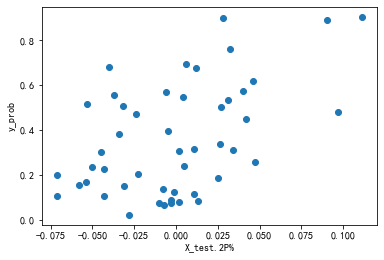

In [8]:
    coefficients = logistic_classifier.model.coef_
    y_prob = logistic_classifier.model.predict_proba(X_test)[:, 1]
    plt.scatter(np.array(X_test)[:, 4], np.array(y_prob))
    #二分球命中率和球队获胜概率的散点图
    plt.xlabel('X_test.2P%')
    plt.ylabel('y_prob')
    plt.show()

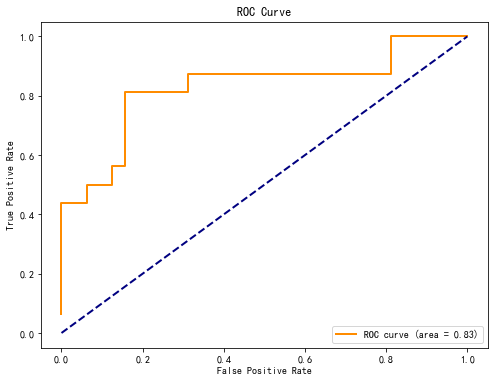

In [9]:
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    # 绘制ROC曲线
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

## 异常解决

In [10]:
    baseclass = BaseClassifier(LogisticRegression())
    try:
        baseclass.train(X_train, y_train)
    except:
        print('tune_hyperparameters method should be implemented in subclasses.')

tune_hyperparameters method should be implemented in subclasses.


## 决策树模型

In [11]:
    # 创建决策树分类器对象
    tree_classifier = DecisionTreeClassifierWrapper()
    tree_classifier.train(X_train, y_train)
    tree_classifier.cross_validate(temp, game_res)
    # 分割数据集并进行训练与评估
    tree_pred=tree_classifier.evaluate(X_test, y_test)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Cross-validated Accuracy: 0.62 (±0.05)
Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Accuracy: 0.67
Classification Report:
              precision    recall  f1-score   support

          0       0.75      0.75      0.75        32
          1       0.50      0.50      0.50        16

avg / total       0.67      0.67      0.67        48



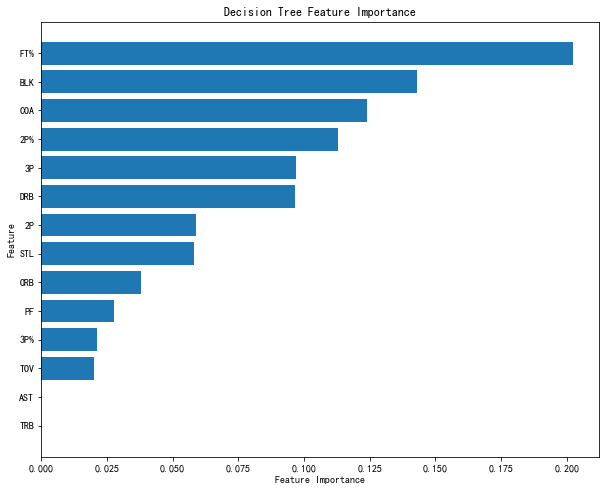

In [12]:
    importances = tree_classifier.model.feature_importances_
    feature_names = np.array(columns)
    # 排序
    sorted_idx = np.argsort(importances)
    # 绘制特征重要性图表
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(importances)), importances[sorted_idx], align='center')
    plt.yticks(range(len(importances)), feature_names[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Decision Tree Feature Importance')
    plt.show()

In [13]:
analyse_res(logit_pred, y_test, f2)  # 分析预测错误结果的原因
temp_det, game_res_det = man_data(f3, X2)
pre_det = logistic_classifier.model.predict(temp_det)  # 预测DET队的胜场
print('底特律活塞队预测结果：')
print(pre_det)

预测错误的场次队伍分数差：
2
-11
7
-5
6
4
1
-45
-4
-8
预测错误的场次队伍战力差：
[  6  16   2   3 -16  17  16  -2 -11  10]
预测错误的场次队伍赛季终排名差：
[  3  -3   3 -12  -7   9  15  -8  -4 -17]
底特律活塞队预测结果：
[1 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 0]
